# This script renames columns and concatenates narratives into a single field for downstream tasks. Splits data into train/test/val by country type. Saves output to:
'../data/phmrc/'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# load redacted data
df = pd.read_csv('../data/phmrc/redacted_adult.csv')

## Combine all narrative text into a single field and check dist of vars

In [3]:
# rename columns
df = df.rename(columns={"age_years": "age_yr"})
df = df.rename(columns={"open_response": "narrative"})

In [4]:
# drop observations without age or narrative observations
df = df.dropna(subset=['age_yr'])
df = df[df['age_yr'] != 999]
df = df.dropna(subset=['narrative'])

In [5]:
# convert types
df['narrative'] = df['narrative'].astype(str)
df['age_yr'] = df['age_yr'].astype(int)

In [6]:
# Convert all column values to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [7]:
# Define the mapping between 'gs_cod' values and broader ICD-10 categories

icd10_mapping = {
    'cirrhosis': 'non-communicable',
    'epilepsy': 'non-communicable',
    'pneumonia': 'communicable',
    'copd': 'non-communicable',
    'acute myocardial infarction': 'non-communicable',
    'fires': 'external',
    'renal failure': 'non-communicable',
    'lung cancer': 'non-communicable',
    'maternal': 'maternal',
    'drowning': 'external',
    'other cardiovascular diseases': 'non-communicable',
    'aids': 'aids-tb',
    'other non-communicable diseases': 'non-communicable',
    'falls': 'external',
    'road traffic': 'external',
    'diabetes': 'non-communicable',
    'other infectious diseases': 'communicable',
    'tb': 'aids-tb',
    'suicide': 'external',
    'other injuries': 'external',
    'cervical cancer': 'non-communicable',
    'stroke': 'non-communicable',
    'malaria': 'non-communicable',
    'asthma': 'non-communicable',
    'colorectal cancer': 'non-communicable',
    'homicide': 'external',
    'diarrhea/dysentery': 'communicable',
    'breast cancer': 'non-communicable',
    'leukemia/lymphomas': 'non-communicable',
    'poisonings': 'external',
    'prostate cancer': 'non-communicable',
    'esophageal cancer': 'non-communicable',
    'stomach cancer': 'non-communicable',
    'bite of venomous animal': 'external'
}

# Create a new column 'gs_cod' using the mapping
df['gs_cod'] = df['gs_text34'].map(icd10_mapping)

In [8]:
# reset index
df = df.reset_index(drop=True)

In [9]:
# # limit to three regions
# regions = ['ap', 'dar', 'up']
# df = df[df['site'].str.contains('|'.join(regions))]

# # limit gs_cod options
# cod_labels = ['drowning', 'fires', 'pneumonia', 'road traffic', 'other defined causes of child deaths']
# df = df[df['gs_cod'].str.contains('|'.join(cod_labels))]

## Pre-processing text

In [10]:
RANDOM_SEED = random.seed(258)

In [13]:
# Tokenization : In this each entry in the corpus will be broken into set of words
df['cleaned'] = [word_tokenize(entry) for entry in df['narrative']]

count_tokens = [token for sublist in df['cleaned'] for token in sublist]


In [15]:
len(count_tokens)

556713

In [17]:
# Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(df['cleaned']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    df.loc[index, 'tags'] = str(Final_words)

In [12]:
total_word_count = df['narrative'].str.split().str.len().sum()
total_word_count_processed = df['tags'].str.split().str.len().sum()
print(f'Word count of narratives is: {int(total_word_count)}')
print(f'Word count of narratives after processing is: {int(total_word_count_processed)}')
print(f'{round((1-(total_word_count - total_word_count_processed)/total_word_count)*100, 2)}% as many words.')

Word count of narratives is: 481385
Word count of narratives after processing is: 218804
45.45% as many words.


In [13]:
df.to_csv('../data/phmrc/phmrc_adult_tokenized.csv', index=False)

## EDA plots

In [14]:
df = pd.read_csv('../data/phmrc/phmrc_adult_tokenized.csv')

In [45]:
# Create a mapping between unique values in 'gs_cod' and colors
palette = sns.color_palette("Set2", n_colors=len(df['gs_cod'].unique()))
unique_cod = df['gs_cod'].unique()
color_mapping = {value: palette[i] for i, value in enumerate(unique_cod)}
# Map colors based on the defined mapping
colors = [color_mapping[value] for value in gs_cod_counts.index]

In [51]:
colors = [(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

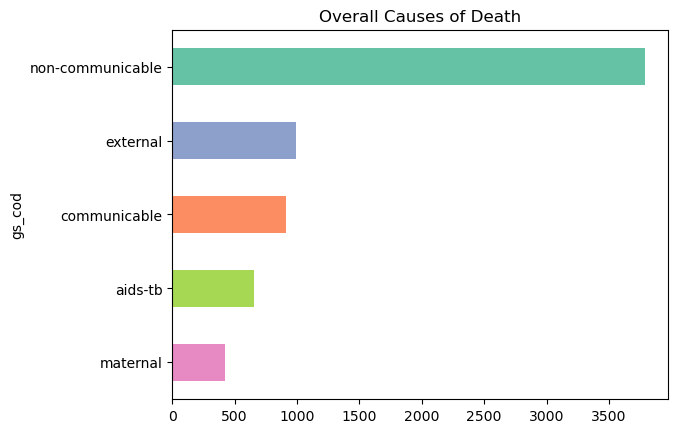

In [52]:
df['gs_cod'].value_counts().plot.barh(title='Overall Causes of Death', color = colors).invert_yaxis()

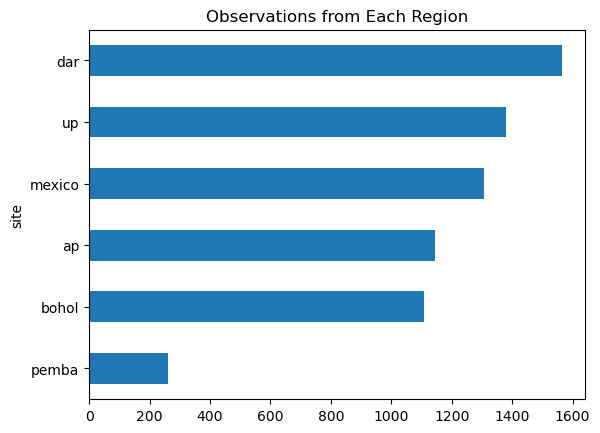

In [53]:
df['site'].value_counts().plot.barh(title='Observations from Each Region').invert_yaxis()

### COD Distribution by Region

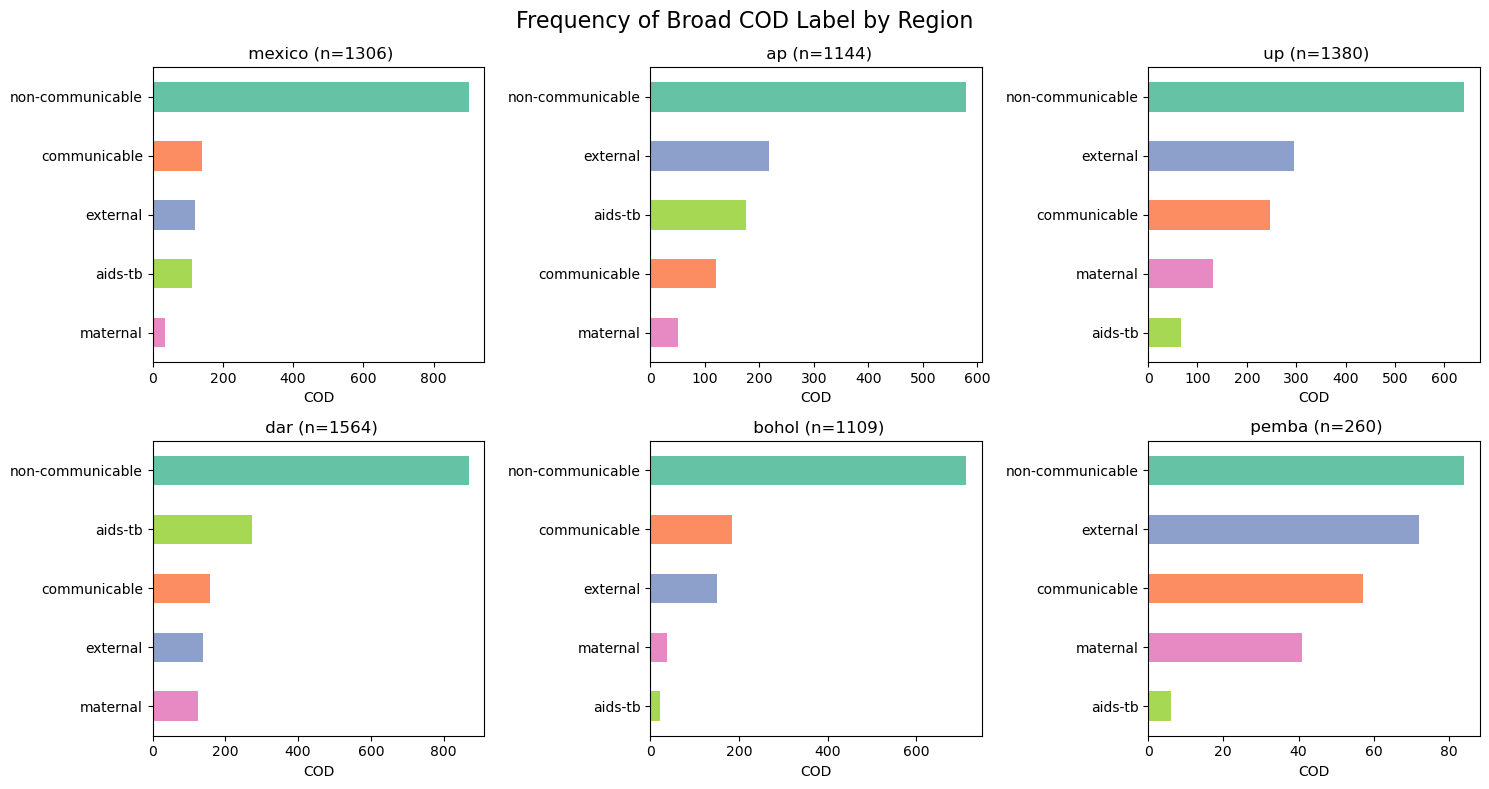

In [54]:
# list of unique regions
regions = list(df['site'].unique())

# Set up subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plotting a separate subplot for each region
for i, region in enumerate(regions):
    # Filter DataFrame for the specific region
    region_df = df[df['site'] == region]
    observations = len(region_df.index)

    # Count occurrences of each unique value in 'gs_cod'
    gs_cod_counts = region_df['gs_cod'].value_counts()
    
    # Map colors based on the defined mapping
    colors = [color_mapping[value] for value in gs_cod_counts.index]
    
    # Plotting with consistent color mapping on each subplot
    gs_cod_counts.plot(kind='barh', color=colors, ax=axes[i])
    axes[i].set_xlabel('COD')
    axes[i].set_ylabel('')
    axes[i].set_title(f' {region} (n={observations})')
    
    # Invert the y-axis
    axes[i].invert_yaxis()
    
# Hide the empty subplot if there are fewer than 6 regions
if len(regions) < 6:
    axes[-1].axis('off')
    
# Add a separate title to the entire figure
fig.suptitle('Frequency of Broad COD Label by Region', fontsize=16)    

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Group by number of gs_cod by region

In [55]:
# Group by 'gs_cod' and 'site' and count the observations
pivot_grouped = df.pivot_table(index='gs_cod', columns='site', aggfunc='size', fill_value=0)

# drop pemba
# pivot_grouped = pivot_grouped[['ap','bohol', 'dar', 'mexico', 'up']]

# Filter gs_cod values with more than n observations for all three sites
n = 30
subset_result = pivot_grouped[pivot_grouped[['up', 'ap', 'dar', 'bohol', 'mexico']].min(axis=1) > n]
subset_result

site,ap,bohol,dar,mexico,pemba,up
gs_cod,,,,,,
communicable,121,185,159,140,57,246
external,217,151,138,121,72,295
maternal,50,38,126,34,41,132
non-communicable,580,713,869,900,84,640


In [56]:
df.shape

(6763, 12)

## Subset to final results

In [57]:
sites_final = ['up', 'ap', 'dar', 'bohol', 'mexico']
cod_final = ['communicable disease', 'non-communicable disease', 'maternal cause', 'external cause']

In [58]:
temp = df[(df['site'].isin(sites_final)) & (df['gs_cod'].isin(cod_final))]

## Train/Test/Val data for each permutation of leave out one country
For manufacturing transportability problem, we need to train using 4/5 countries, and then use the 5th for test/val. And need to do that 5 times where a different country is left out each time. 

### Train

In [59]:
# Create separate subsets where each region is excluded
for region in regions:
    train_excluded = df[df['site'] != region].copy()
    train_excluded.to_csv(f'../data/train_test_val/train_ex_{region}.csv', index=False)

In [60]:
# Read in CSV files and store in dictionary
train_excluded_dict = {}
for region in regions:
    file_path = f'../data/train_test_val/train_ex_{region.lower()}.csv'
    train_excluded_dict[region] = pd.read_csv(file_path)

In [61]:
# assign training data df names
train_ex_ap = train_excluded_dict['ap']
train_ex_dar = train_excluded_dict['dar']
train_ex_pemba = train_excluded_dict['pemba']
train_ex_mexico = train_excluded_dict['mexico']
train_ex_bohol = train_excluded_dict['bohol']
train_ex_up = train_excluded_dict['up']

### Test/Val 
20/80 split for test/val


In [62]:
regions

['mexico', 'ap', 'up', 'dar', 'bohol', 'pemba']

In [63]:
# perform test/val split for each region from excluded files
for region in regions:
    temp = df[df['site'] == region]
    
    # Split the DataFrame into 80% training (val) and 20% testing (test)
    train_df, test_df = train_test_split(temp, test_size=0.8, random_state=42)
    
    # Save the test and val DataFrames to CSV files
    train_df.to_csv(f'../data/train_test_val/test_{region}.csv', index=False)
    test_df.to_csv(f'../data/train_test_val/val_{region}.csv', index=False)

In [64]:
# Dictionary to store DataFrames
test_dict = {}
val_dict = {}

# Read in test and validation CSV files and store in dictionaries
for region in regions:
    test_file_path = f'../data/train_test_val/test_{region}.csv'
    val_file_path = f'../data/train_test_val/val_{region}.csv'
    
    test_dict[region] = pd.read_csv(test_file_path)
    val_dict[region] = pd.read_csv(val_file_path)

In [65]:
# assign test and val data df names
test_ap = test_dict['ap']
test_dar = test_dict['dar']
test_pemba = test_dict['pemba']
test_mexico = test_dict['mexico']
test_bohol = test_dict['bohol']
test_up = test_dict['up']

val_ap = val_dict['ap']
val_dar = val_dict['dar']
val_pemba = val_dict['pemba']
val_mexico = val_dict['mexico']
val_bohol = val_dict['bohol']
val_up = val_dict['up']

In [66]:
# write out cleaned data file
df.to_csv('../data/phmrc/phmrc_adult_tokenized.csv', index=False)

## COD by region comparing UP to OTHER

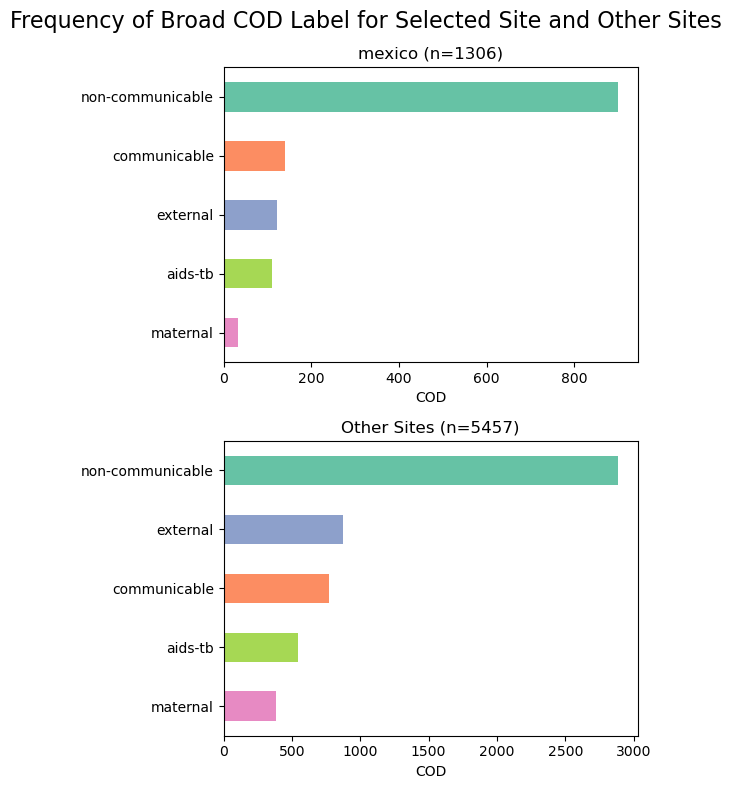

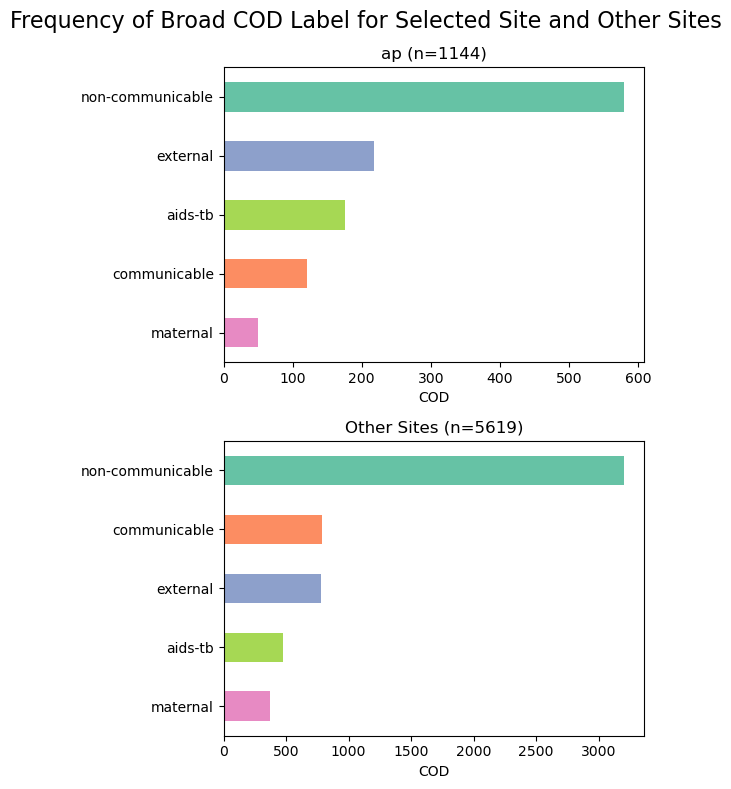

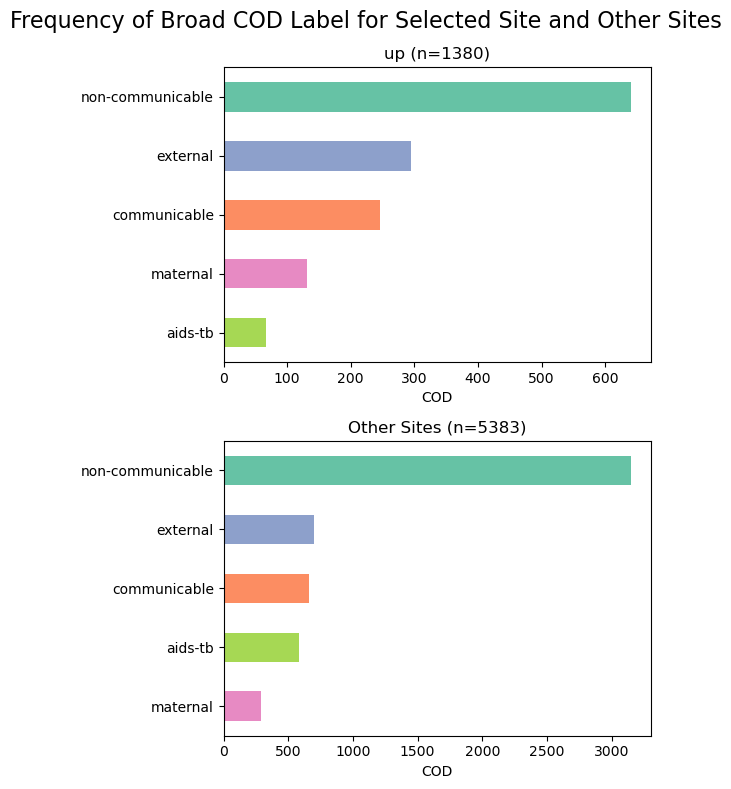

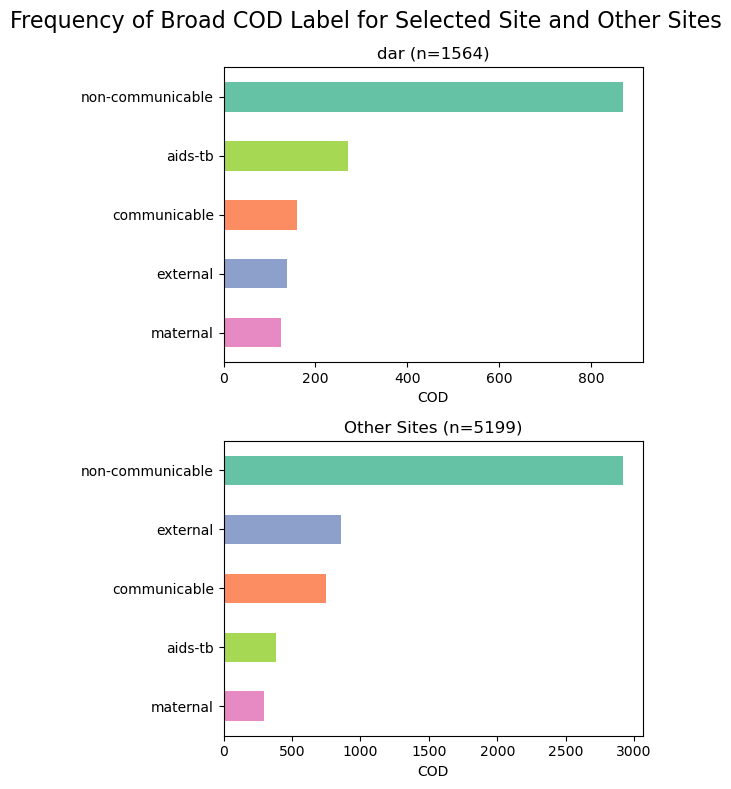

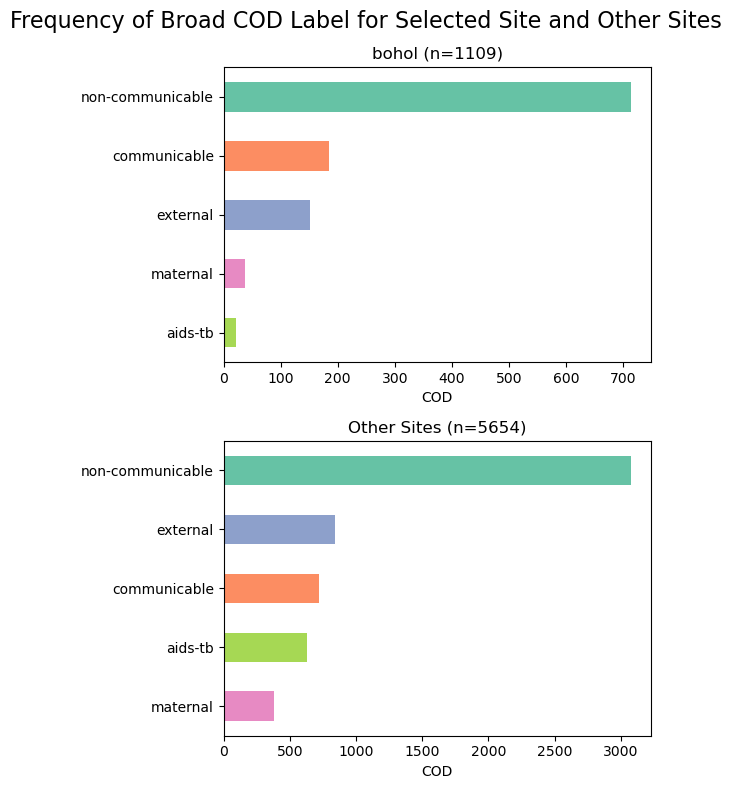

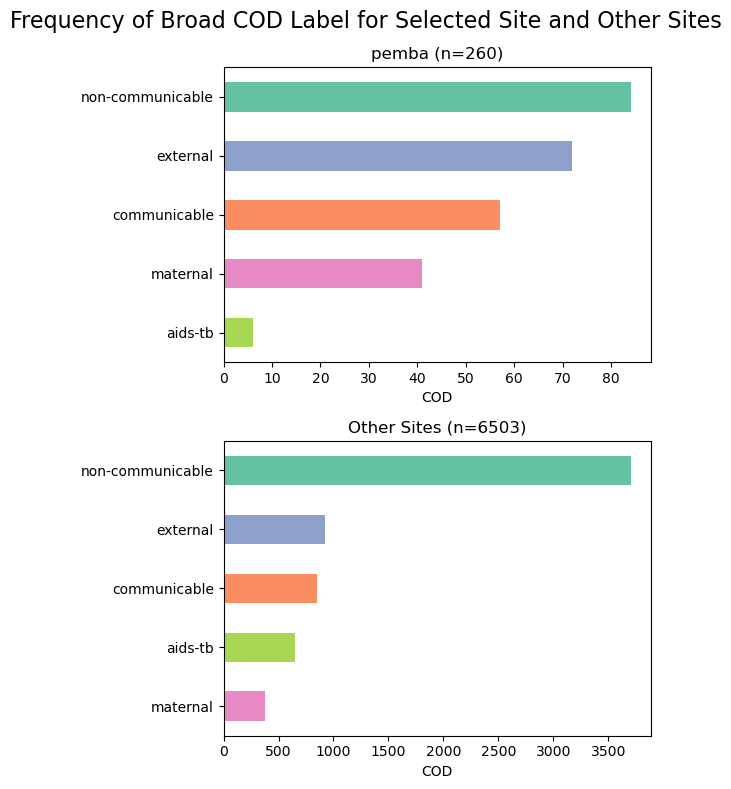

In [67]:
for region in regions:
    # Filter DataFrame for the selected site
    selected_site = region
    selected_site_df = df[df['site'] == selected_site]

    # Create a mapping between unique values in 'gs_cod' and colors
    colors = sns.color_palette("Set2", n_colors=len(df['gs_cod'].unique()))
    unique_cod = df['gs_cod'].unique()
    color_mapping = {value: colors[i] for i, value in enumerate(unique_cod)}

    # Set up subplots in a 2x1 grid
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

    # Plotting for the selected site
    selected_site_counts = selected_site_df['gs_cod'].value_counts()
    selected_site_colors = [color_mapping[value] for value in selected_site_counts.index]
    selected_site_counts.plot(kind='barh', color=selected_site_colors, ax=axes[0])
    axes[0].set_xlabel('COD')
    axes[0].set_ylabel('')
    axes[0].set_title(f'{region} (n={len(selected_site_df)})')
    axes[0].invert_yaxis()

    # Plotting for all other sites combined
    other_sites_df = df[df['site'] != selected_site]
    other_sites_counts = other_sites_df['gs_cod'].value_counts()
    other_sites_colors = [color_mapping[value] for value in other_sites_counts.index]
    other_sites_counts.plot(kind='barh', color=other_sites_colors, ax=axes[1])
    axes[1].set_xlabel('COD')
    axes[1].set_ylabel('')
    axes[1].set_title(f'Other Sites (n={len(other_sites_df)})')
    axes[1].invert_yaxis()

    # Add a separate title to the entire figure
    fig.suptitle('Frequency of Broad COD Label for Selected Site and Other Sites', fontsize=16)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()